In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spellchecker import SpellChecker

In [ ]:
from typing import List, Dict
from collections import defaultdict
from enum import Enum

class Category(Enum):
    SMALL = 1
    MEDIUM = 2
    LARGE = 3
    INCOME = 4


class Account():
    def __init__(self, name: str,
                       type: str = None,
                       currency: str = None,
                       opening_date: str = None,
                       description: str = None,
                       initial_balance: float = 0.0):
        self.name = name
        self.initial_balance = initial_balance
        self.type = type
        self.currency = currency
        self.opening_date = opening_date
        self.description = description

    def deposit(self, amount: float):
        self.balance += amount

    def withdraw(self, amount: float):
        self.balance -= amount

    def get_balance(self) -> float:
        return self.balance

class Transaction:
    def __init__(self, name: str = None,
                 date: str = None,
                 currency: str = None,
                 amount: float = 0.0,
                 account: str = None,
                 description: str = None,
                 category: Category = None,
                 tags: list = None,
                 recurring: bool = False,
                 frequency: str = None,
                 inout: str = None,
                 id: str = None):
        self.name = name
        self.date = date
        self.currency = currency
        self.amount = amount
        self.account = account
        self.description = description
        if isinstance(category, str):
            try:
                self.category = Category[category.upper()]
            except KeyError:
                #self.category = None
                raise ValueError(f"Invalid category: {category}. Must be one of {list(Category)}.")
        elif isinstance(category, Category):
            self.category = category
        else:
            self.category = None
            #raise TypeError("Category must be a string or an instance of Category Enum.")
        #self.category = category
        self.tags = tags if tags is not None else []
        self.recurring = recurring
        self.frequency = frequency
        self.inout = inout

        if name is None or date is None or amount == 0.0 or inout is None:
            raise ValueError("Name, date, amount, and inout are required fields.")
        if id is not None:
            self.id = id
        else:
            self.id = self.create_id()

    def create_id(self) -> str:
        """Create a unique ID for the expense based on its attributes."""
        return f"{self.name}_{self.date}_{self.amount}_{self.currency}"

    def print(self):
        """Print the expense details."""
        print(f"Name: {self.name}, Date: {self.date}, Currency: {self.currency}, "
              f"Amount: {self.amount}, Bank: {self.account}, Description: {self.description}, "
              f"Category: {self.category}, Tags: {', '.join(self.tags)}, "
              f"Recurring: {self.recurring}, Frequency: {self.frequency}, In/Out: {self.inout}, ID: {self.id}")

    def to_dict(self) -> dict:
        """Convert an Transaction object to a dictionary suitable for DataFrame."""
        return {
            'name': self.name,
            'date': self.date,
            'currency': self.currency,
            'amount': self.amount,
            'account': self.account,
            'description': self.description,
            'category': self.category,
            'tags': ','.join(self.tags) if isinstance(self.tags, list) else self.tags,
            'recurring': self.recurring,
            'frequency': self.frequency,
            'inout': self.inout,
            'id': self.id
        }

    def from_dict(self, dict) -> 'Transaction':
        """Convert a dictionary to an Transaction object."""
        return Transaction(
            name=dict.get('name'),
            date=dict.get('date'),
            currency=dict.get('currency'),
            amount=dict.get('amount'),
            account=dict.get('account'),
            description=dict.get('description'),
            category=dict.get('category'),
            tags=dict.get('tags').split(',') if isinstance(dict.get('tags'), str) else [],
            recurring=dict.get('recurring'),
            frequency=dict.get('frequency'),
            inout=dict.get('inout'),
            id=dict.get('id')
        )

    def __eq__(self, other):
        """Check if two Expense objects are equal based on their attributes."""
        if not isinstance(other, Transaction):
            return False
        return (self.id == other.id)

    def update(self, newValue: Dict[str, any]):
        """Update the Expense object with new values."""
        prev_values = self.to_dict()
        print(f"Updating Expense ID {self.id} from {prev_values} to {newValue}")
        for key, value in newValue.items():
            if key in prev_values and prev_values[key] != value:
                setattr(self, key, value)

class EiFinance:
    def __init__(self, filenameExpenses: str, filenameAccounts: str):
        self.filenameExpenses = filenameExpenses
        self.filenameAccounts = filenameAccounts
        self.expenses: List[Transaction] = []
        self.accounts: List[Account] = []
        self.load_expenses()
        self.load_accounts()
        self.tags = []
        self.spell = SpellChecker()
        self.get_tags()
        self.current_day = pd.Timestamp.now().normalize()  # Get the current date without time

    def load_expenses(self):
        """Load expenses from a CSV file into the expenses list."""
        try:
            df = pd.read_csv(self.filenameExpenses)
            for _, row in df.iterrows():
                expense = Transaction(
                    name=row['name'],
                    date=row['date'],
                    currency=row['currency'],
                    amount=row['amount'],
                    account=row['account'],
                    description=row['description'],
                    category=row['category'],
                    tags=row['tags'].split(',') if isinstance(row['tags'], str) else [],
                    recurring=row['recurring'],
                    frequency=row['frequency'],
                    inout=row['inout'],
                    id=row['id']
                )
                self.expenses.append(expense)
        except FileNotFoundError:
            print(f"File {self.filenameExpenses} not found. Starting with an empty expense list.")

    def load_accounts(self):
        """Load accounts from a CSV file into the accounts list."""
        try:
            df = pd.read_csv(self.filenameAccounts)
            for _, row in df.iterrows():
                account = Account(
                    name=row['name'],
                    type=row.get('type'),
                    currency=row.get('currency'),
                    opening_date=row.get('opening_date'),
                    description=row.get('description', ""), # Default to empty string if not provided
                    initial_balance=row.get('initial_balance', 0.0)  # Default to 0.0 if not provided
                )
                self.accounts.append(account)
        except FileNotFoundError:
            print(f"File {self.filenameAccounts} not found. Starting with an empty account list.")

    def get_tags(self):
        """Get a list of unique tags from the expenses."""
        tags = set()
        for expense in self.expenses:
            for tag in expense.tags:
                if tag:
                    strip_tag = tag.strip()
                    misspelled = self.spell.unknown([strip_tag])
                    if misspelled:
                        for word in misspelled:
                            correction = self.spell.correction(word)
                            print(f"'{word}' might be a typo. Did you mean '{correction}'?")
                            tags.add(correction)

                            # Replace the misspelled tag in the expense's tags
                            expense.tags = [t if t != word else correction for t in expense.tags]
                    else:
                        tags.add(strip_tag)
        # Convert set to list and return
        tags = sorted(tags)
        self.tags = list(tags)

    def get_incomplete_expenses(self, field: str = None) -> List[Transaction]:
        """Get a list of expenses that are missing required fields."""
        incomplete_expenses = []
        if field not in ['name', 'date', 'currency', 'amount', 'account', 'description', 'category', 'tags', 'recurring', 'frequency', 'inout']:
            raise ValueError(f"Invalid field: {field}")

        for expense in self.expenses:
            value = expense.to_dict().get(field)
            if value is None or (isinstance(value, float) and pd.isna(value)) or value == '' or value == []:
                incomplete_expenses.append(expense)
        return incomplete_expenses

    def plot_accounts(self, currency: str = 'USD'):
        """Plot the balance of each account."""
        account_names = [account.name for account in self.accounts if getattr(account, 'currency', None) == currency]
        filtered_accounts = [account for account in self.accounts if getattr(account, 'currency', None) == currency]
        balances = [account.get_balance() for account in filtered_accounts]
        balances = [account.get_balance() for account in self.accounts]

        plt.figure(figsize=(10, 6))
        plt.bar(account_names, balances, color='skyblue')
        plt.xlabel('Accounts')
        plt.ylabel('Balance')
        plt.title('Account Balances')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def add_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        existing_df = pd.read_csv(filename)
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        combined_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    combined_df.to_csv(filename, index=False)

def save_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    new_df.to_csv(filename, index=False)

def add_expense2expenses(expenses: List[Transaction], existing_expenses: List[Transaction]) -> List[Transaction]:
    for expense in expenses:
        # Check if the expense already exists in the existing expenses
        if not any(existing_expense.id == expense.id for existing_expense in existing_expenses):
            existing_expenses.append(expense)
        else:
            print(f"Transaction with ID {expense.id} already exists. Skipping.")
    return existing_expenses

def read_expenses_from_csv(csv) -> List[Transaction]:
    df = pd.read_csv(csv)

#    for idx, row in df.iterrows():
        # You can access each row as a Series, e.g. row['name'], row['amount'], etc.
#        print(row)
    expenses = []
    for _, row in df.iterrows():
        expense = Transaction(
            name=row.get('name'),
            date=row.get('date'),
            currency=row.get('currency'),
            amount=row.get('amount'),
            account=row.get('account'),
            description=row.get('description'),
            category=row.get('category'),
            tags=row.get('tags').split(',') if isinstance(row.get('tags'), str) else [],
            recurring=row.get('recurring') in [True, 'True', 'true', 'yes', 'Yes'],
            frequency=row.get('frequency'),
            inout=row.get('inout'),
            id=row.get('id') if pd.notnull(row.get('id')) else None
        )
        expenses.append(expense)
    return expenses

def get_expenses_cost(expenses: List[Transaction]) -> float:
    """Calculate the total cost of all expenses."""
    total_cost = sum(expense.amount for expense in expenses if expense.inout == 'out')
    return total_cost
def get_expenses_income(expenses: List[Transaction]) -> float:
    """Calculate the total income from all expenses."""
    total_income = sum(expense.amount for expense in expenses if expense.inout == 'in')
    return total_income
def get_expenses_balance(expenses: List[Transaction]) -> float:
    """Calculate the balance from all expenses."""
    total_cost = get_expenses_cost(expenses)
    total_income = get_expenses_income(expenses)
    return total_income - total_cost

def draw_piechart(expenses: List[Transaction], by: str = 'category', title: str = None):
    """
    Draw a pie chart of expenses grouped by a specified attribute.
    Args:
        expenses: List of Transaction objects.
        by: Attribute to group by ('category', 'tags', or 'account').
        title: Title for the chart. If None, a default will be used.
    """
    title = title + " " + by.capitalize() if title else None

    data = defaultdict(float)
    if by == 'tags':
        for expense in expenses:
            if expense.tags:
                for tag in expense.tags:
                    if tag:
                        data[tag.strip()] += expense.amount
    elif by == 'category':
        for expense in expenses:
            key = expense.category if expense.category else 'Uncategorized'
            data[key] += expense.amount
    elif by == 'account':
        for expense in expenses:
            key = expense.account.strip() if expense.account else 'Unknown Bank'
            data[key] += expense.amount
    else:
        for expense in expenses:
            key = getattr(expense, by, None)
            if key:
                data[key] += expense.amount

    if not data:
        print(f"No data to plot for '{by}'.")
        return

    if title is None:
        title = f"Expenses by {by.capitalize()}"

    plt.figure(figsize=(10, 6))
    plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def get_expenses_banks(expenses: List[Transaction], account: str) -> List[Transaction]:
    """Print the unique banks from the expenses."""
    return [expense for expense in expenses if expense.account == account]


In [ ]:

csv = 'data/transactions.csv'
expense_db = EiFinance(csv)

new_expense = Transaction(
    name='Groceries',
    date='2023-10-03',
    currency='USD',
    amount=150.00,
    description='Weekly grocery shopping',
    category='MEdium',
    tags=['groceries', 'food'],
    recurring=False,
    frequency=None,
    inout='out'
)

new_expense.print()
expense_db.expenses = add_expense2expenses([new_expense], expense_db.expenses)
save_expense2csv(expense_db.expenses, csv)

print("Unique Tags:", expense_db.tags)


Name: Groceries, Date: 2023-10-03, Currency: USD, Amount: 150.0, Bank: None, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: None, In/Out: out, ID: Groceries_2023-10-03_150.0_USD
Expense with ID Groceries_2023-10-03_150.0_USD already exists. Skipping.
Unique Tags: ['food', 'groceries', 'salary']


Name: Groceries, Date: 2023-10-01, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: Groceries_2023-10-01_150.0_USD
Name: Groceries, Date: 2023-10-02, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: Groceries_2023-10-02_150.0_USD


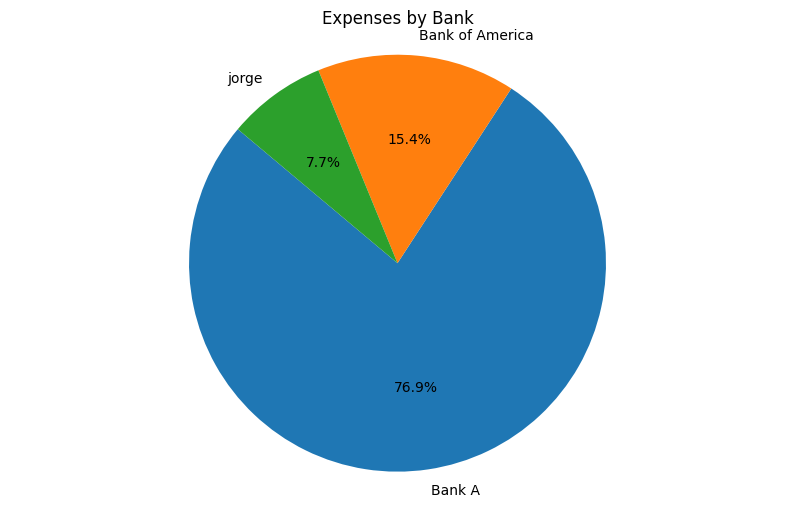

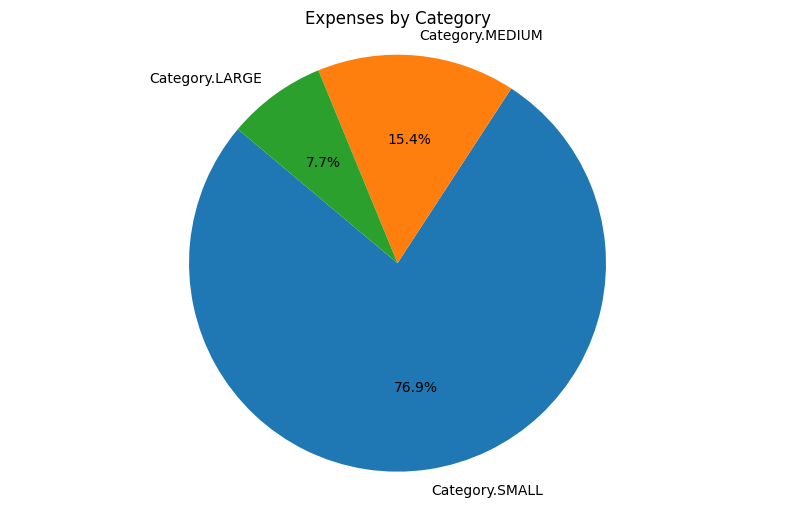

In [ ]:

bank_expenses = get_expenses_banks(expense_db.expenses, 'Bank of America')
for expense in bank_expenses:
    expense.print()

draw_piechart(expense_db.expenses, 'account', 'Expenses by')
draw_piechart(expense_db.expenses, 'category', 'Expenses by')
for expense in expense_db.get_incomplete_expenses('account'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'account': 'jorge'})

for expense in expense_db.get_incomplete_expenses('category'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'category': 'small'})

save_expense2csv(expense_db.expenses, expense_db.filename)